In [ ]:
import cv2
import numpy as np
import os
from pdf2image import convert_from_path
from PIL import Image
from matplotlib import pyplot as plt

In [638]:
def convert_pdf_folder_to_images(pdf_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(pdf_folder):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_folder, filename)
            images = convert_from_path(pdf_path)
            base_filename = os.path.splitext(filename)[0]
            for page_num, img in enumerate(images):
                output_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}.jpg")
                img.save(output_path, 'JPEG')
                
                width, height = img.size
                left_half = img.crop((0, 0, width // 2, height))
                right_half = img.crop((width // 2, 0, width, height))

                left_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_left.jpg")
                right_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_right.jpg")
                
                left_half.save(left_half_path, 'JPEG')
                right_half.save(right_half_path, 'JPEG')
                
pdf_folder = './scan/datas/pdf'  # PDF 파일이 있는 폴더 경로
image_output_folder = './scan/datas/pdf/divided'  # 출력 이미지 파일을 저장할 폴더 경로

convert_pdf_folder_to_images(pdf_folder, image_output_folder)

In [642]:
def is_square(cnt, min_area, max_area):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    # 정사각형은 꼭지점이 4개여야 함
    if len(approx) != 4:
        return False

    # 각도와 비율 체크
    for i in range(4):
        pt1 = approx[i][0]
        pt2 = approx[(i + 1) % 4][0]
        pt3 = approx[(i + 2) % 4][0]
        
        vec1 = pt2 - pt1
        vec2 = pt3 - pt2
        
        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        magnitude1 = np.sqrt(vec1[0]**2 + vec1[1]**2)
        magnitude2 = np.sqrt(vec2[0]**2 + vec2[1]**2)
        
        cos_angle = dot_product / (magnitude1 * magnitude2)
        angle = np.arccos(cos_angle) * (180 / np.pi)
        
        if angle < 80 or angle > 100:  # 각도가 직각에 가까운지 체크
            return False
    
    # 가로와 세로의 길이가 거의 같은지 확인
    x, y, w, h = cv2.boundingRect(approx)
    if abs(w - h) > min(w, h) * 0.1:  # 정사각형 비율이 아닌 경우 제외
        return False
    
    area = cv2.contourArea(cnt)
    if area < min_area or area > max_area:
        return False

    return True

def draw_contours(image_folder, output_folder, min_area=100, max_area=1000):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cut_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and (("_left" in filename) or ("_right" in filename)):
            image_path = os.path.join(image_folder, filename)
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (9, 9), 0)

            # 경계 검출 (Canny Edge Detection)
            edges = cv2.Canny(blurred, 50, 100) # 50 100

            # 윤곽선 검출
            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # 사각형 및 크기 필터링
            rectangles = [cnt for cnt in contours if is_square(cnt, min_area, max_area)]
            rectangles = rectangles[:2] + rectangles[-2:]
            # 원본 이미지에 윤곽선 그리기
            # x 좌표와 y 좌표가 가장 작은 점이 좌상단 (top-left).
            # x 좌표는 크지만 y 좌표가 작은 점이 우상단 (top-right).
            # x 좌표는 작지만 y 좌표가 큰 점이 좌하단 (bottom-left).
            # x 좌표와 y 좌표가 모두 큰 점이 우하단 (bottom-right).
            cut_xy = []
            for rdx, rect in enumerate(rectangles):
                x, y, w, h = cv2.boundingRect(rect)
                if rdx == 0: # 우하단
                    cut_xy += [x + w]
                    cut_xy += [y + h]
                if rdx == 3: # 좌상단
                    cut_xy = [x, y] + cut_xy
                # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 5)
            cut_xy = tuple(cut_xy)
            img = img[cut_xy[1]:cut_xy[3], cut_xy[0]:cut_xy[2]]
            
            # 결과 이미지 저장
            result_image_path = os.path.join(output_folder, f"square_{filename}")
            cv2.imwrite(result_image_path, img)
            # cropped_image.save(result_image_path)
            cut_dict.update({filename:cut_xy})
            
    return filename, cut_dict

# 사용 예시
image_output_folder = './scan/datas/pdf/divided'
contour_output_folder = './scan/datas/pdf/square'  # 네모를 기준으로 자른 사진을 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
filename, cut_dict = draw_contours(image_output_folder, contour_output_folder)

In [664]:
def is_circle(cnt, min_radius, max_radius):
    # 최소 외접 원 구하기
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    radius = int(radius)
    if radius < min_radius or radius > max_radius:
        return False
    
    # 윤곽선의 면적과 최소 외접 원의 면적 비교
    circle_area = np.pi * (radius ** 2)
    contour_area = cv2.contourArea(cnt)
    if contour_area / circle_area < 0.8:
        return False

    # 타원 적합도 확인
    if len(cnt) >= 5:  # 타원을 적합하기 위해 최소 5개의 점이 필요
        ellipse = cv2.fitEllipse(cnt)
        (center, axes, orientation) = ellipse
        major_axis_length = max(axes)
        minor_axis_length = min(axes)
        eccentricity = np.sqrt(1 - (minor_axis_length / major_axis_length) ** 2)
        
        # 원에 가까운 정도를 확인 (이심률이 낮을수록 원에 가까움)
        if eccentricity > 0.5:  # 이심률이 0.5보다 크면 원형이 아님
            return False

    return True

def draw_contours(image_folder, output_folder, min_radius=9, max_radius=15): # 여기는 문제 없음
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and (("_left" in filename) or ("_right" in filename)):
            image_path = os.path.join(image_folder, filename)
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (9, 9), 0)

            # 경계 검출 (Canny Edge Detection)
            edges = cv2.Canny(blurred, 50, 100) # 50 100

            # 윤곽선 검출
            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # 원형 및 크기 필터링
            large_contours = [cnt for cnt in contours if is_circle(cnt, min_radius, max_radius)]

            # 원본 이미지에 윤곽선 그리기
            cv2.drawContours(img, large_contours, -1, (255, 0, 0), 2)

            # if filename == 'square_FIT_page_2_right.jpg':
            #     for cnt in new_points:
            #         cv2.circle(img, cnt, 3, (0, 0, 255), -1)  # 중심에 파란색 점 그리기
                    
            # 결과 이미지 저장
            result_image_path = os.path.join(output_folder, f"circles_{filename}")
            cv2.imwrite(result_image_path, img)
    return large_contours

image_output_folder = './scan/datas/pdf/square' 
contour_output_folder = './scan/datas/pdf/circles'  # 동그라미 검출 이미지를 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
large_contours = draw_contours(image_output_folder, contour_output_folder)


---

In [526]:
cut_dict

{'FIT_page_1_left.jpg': (46, 46, 1607, 2292),
 'FIT_page_1_right.jpg': (46, 46, 1607, 2292),
 'FIT_page_2_left.jpg': (46, 46, 1607, 2292),
 'FIT_page_2_right.jpg': (46, 46, 1607, 2292),
 'POWER_page_1_left.jpg': (46, 46, 1607, 2292),
 'POWER_page_1_right.jpg': (46, 46, 1607, 2292),
 'POWER_page_2_left.jpg': (46, 46, 1607, 2292),
 'POWER_page_2_right.jpg': (46, 46, 1607, 2292),
 'POWER_page_3_left.jpg': (46, 46, 1607, 2292),
 'POWER_page_3_right.jpg': (46, 46, 1607, 2292),
 'POWER_page_4_left.jpg': (46, 46, 1607, 2292),
 'POWER_page_4_right.jpg': (46, 46, 1607, 2292)}

x+y가 가장 큰 key: 2
x+y가 가장 작은 key: 18


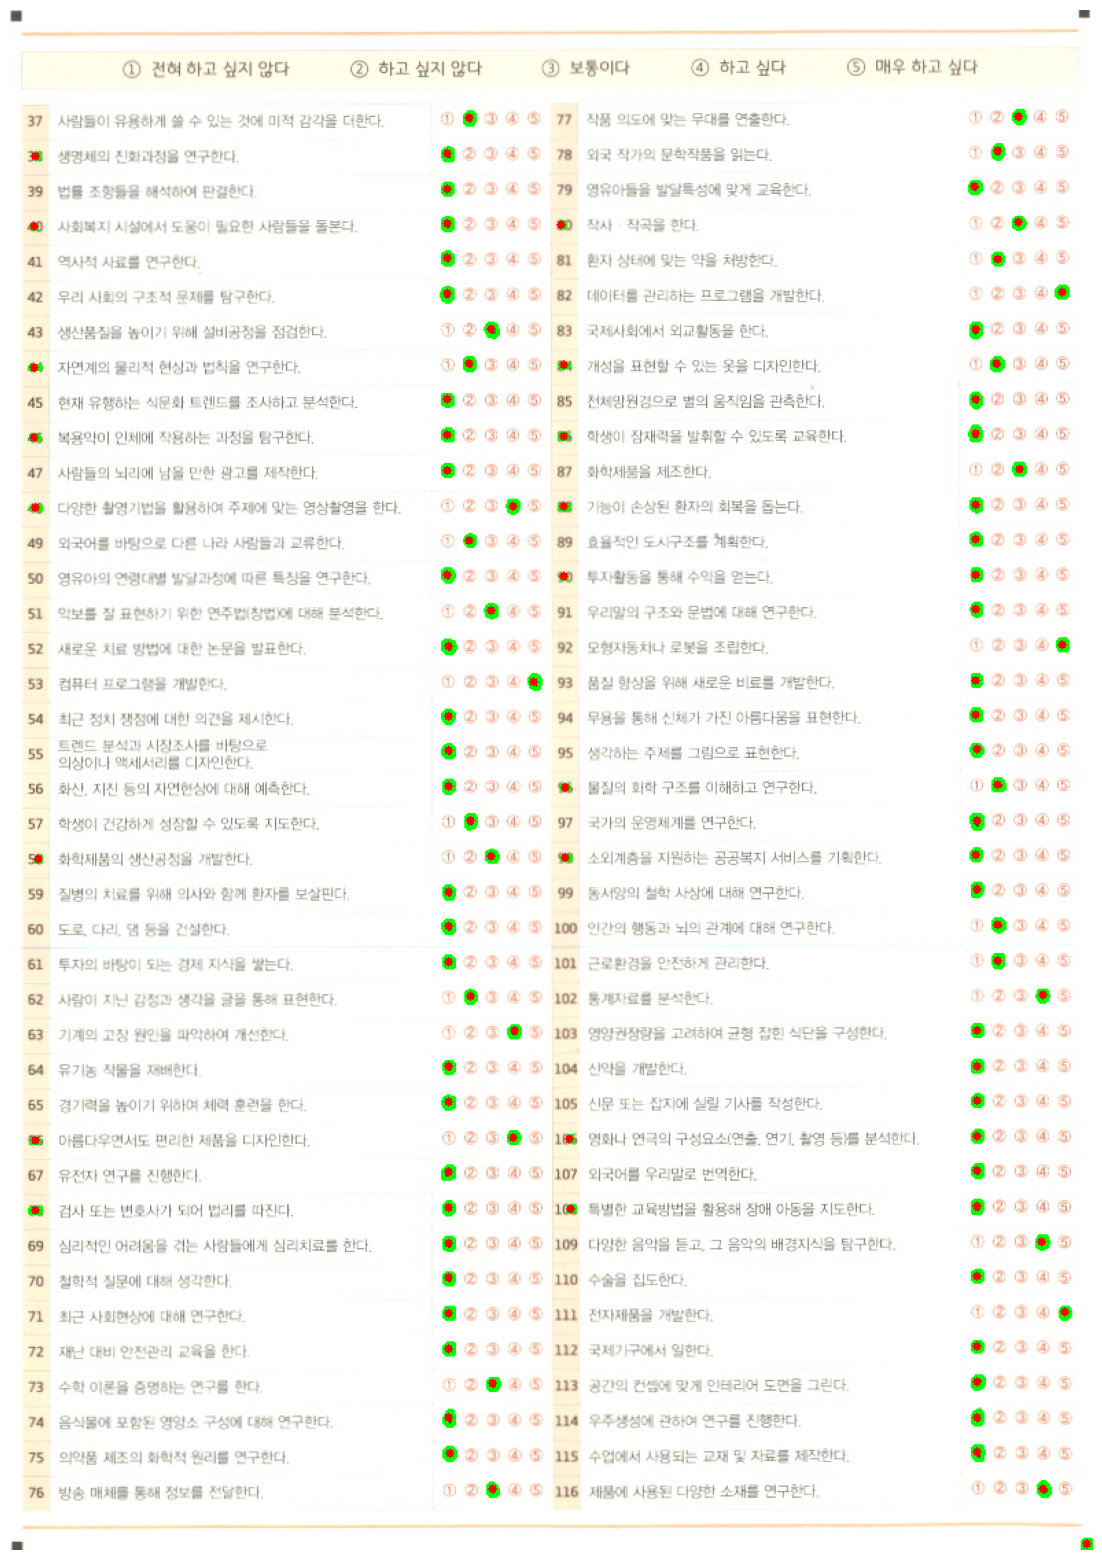

In [694]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('./scan/datas/FIT/0004.jpg')

# 그레이스케일 변환
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 블러링을 통해 노이즈 제거
blurred = cv2.GaussianBlur(gray, (9, 9), 0)

# 바이너리 스레시홀딩
_, binary = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY_INV)

# 외곽선 찾기
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 색칠된 동그라미만 남기기 위해 필터링
filtered_contours = [cnt for cnt in contours if (cv2.contourArea(cnt) > 10) and (cv2.contourArea(cnt) < 150)]
######
rectangles = filtered_contours[:10] + filtered_contours[-10:]
rect_dict = dict()
cut_xy = []

for rdx, rect in enumerate(rectangles):
    x, y, w, h = cv2.boundingRect(rect)
    rect_dict[rdx] = [x, y, w, h]

max_sum = float('-inf')
min_sum = float('inf')

for key, (x, y, w, h) in rect_dict.items():
    current_sum = x + y
    if current_sum > max_sum:
        max_sum = current_sum
        max_key = key
    if current_sum < min_sum:
        min_sum = current_sum
        min_key = key
print("x+y가 가장 큰 key:", max_key) # 우하단
print("x+y가 가장 작은 key:", min_key) # 좌상단
x, y = rect_dict[min_key][:2]
xw, yh = rect_dict[max_key][0] + rect_dict[max_key][2], rect_dict[max_key][1] + rect_dict[max_key][3]
image = image[y:yh, x:xw]

######
shifted_contours = []
for cnt in filtered_contours[2:-2]:
    shifted_cnt = np.array(cnt)
    shifted_cnt[:, :, 0] -= x  
    shifted_cnt[:, :, 1] -= y  
    shifted_contours.append(shifted_cnt)
    
# 원본 이미지에 외곽선 그리기
output_image = image.copy()
cv2.drawContours(output_image, shifted_contours, -1, (0, 255, 0), 2)

point_list = []
for cnt in shifted_contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(output_image, (cX, cY), 3, (0, 0, 255), -1)  # 중심에 파란색 점 그리기
        point_list.append([cX, cY])

# 결과 이미지 보기
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

789 1122
1561 2246
1.9784537389100127 2.001782531194296
[[784, 1117], [351, 1077], [752, 1077], [320, 1051], [704, 1050], [704, 1025], [319, 1025], [351, 1000], [704, 999], [319, 975], [704, 973], [768, 948], [319, 949], [319, 923], [704, 922], [319, 898], [751, 897], [18, 874], [408, 873], [319, 872], [704, 871], [319, 846], [704, 845], [18, 823], [407, 822], [366, 821], [704, 820], [319, 795], [704, 794], [319, 769], [704, 769], [367, 743], [704, 743], [752, 717], [335, 718], [319, 693], [719, 692], [319, 667], [719, 666], [319, 642], [704, 640], [404, 617], [20, 618], [350, 616], [703, 615], [704, 590], [335, 590], [404, 566], [319, 565], [719, 564], [704, 538], [319, 539], [319, 514], [703, 513], [703, 488], [381, 489], [319, 463], [766, 462], [350, 437], [703, 436], [403, 412], [703, 411], [318, 411], [334, 386], [703, 385], [18, 362], [403, 361], [366, 361], [703, 360], [318, 335], [735, 334], [17, 311], [403, 310], [318, 309], [703, 308], [318, 283], [703, 283], [17, 260], [403,

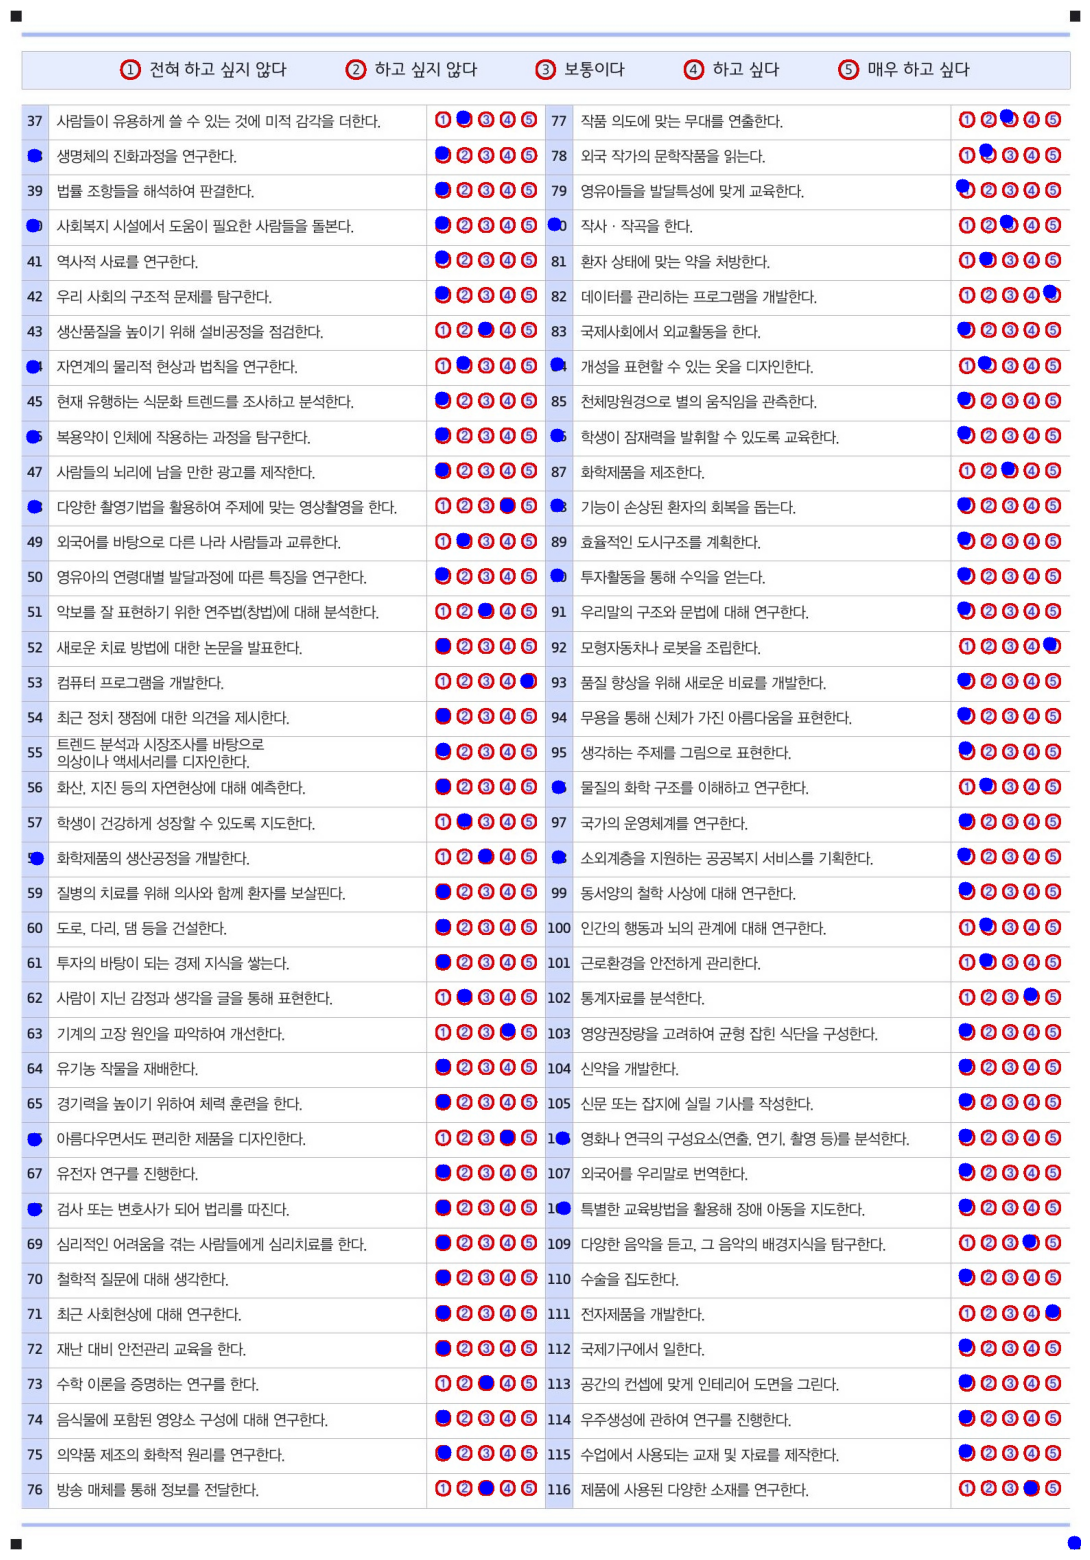

In [695]:
img = cv2.imread('./scan/datas/pdf/circles/circles_square_FIT_page_2_left.jpg')

point_height, point_width = image.shape[:2]
height, width = img.shape[:2]
print(point_width, point_height)
print(width, height)

# 비율 계산
x_ratio = width / point_width
y_ratio = height/ point_height
print(x_ratio, y_ratio)

new_points = [(int(x * x_ratio), int(y * y_ratio)) for (x, y) in point_list]
print(point_list)
print(new_points)


for cnt in new_points:
    cv2.circle(img, cnt, 10, (0, 0, 255), -1)  # 중심에 파란색 점 그리기


plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()